# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Открытие и изучение файлов

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [71]:
# Вывод информации о структуре датафрейма
def df_info(df):
    all_data = df.reset_index(drop=True)    
    all_data_na = (all_data.isna().sum() / len(all_data))
    missing_data = pd.DataFrame({'тип': df.dtypes})
    if len(all_data_na[all_data_na!=0])>0:
        missing_data['пропуски']= all_data_na.map("{:.1%}".format)
        display(missing_data)
        print('Столбцов с NA:',len(all_data_na[all_data_na!=0]),'из',df.shape[1])
    else:
        display(missing_data)
        print('Пропусков нет.') 
    if df.duplicated().sum()>0:
        print('Дубликатов:',df.duplicated().sum())
    else:
        print('Дубликатов нет')
    print(f'Структура : {all_data.shape}')

In [72]:
df=pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [73]:
df_info(df)

,тип
calls,float64
minutes,float64
messages,float64
mb_used,float64
is_ultra,int64


Пропусков нет.
Дубликатов нет
Структура : (3214, 5)


In [74]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


## Разбиение данных на выборки

In [75]:
features = df.drop('is_ultra',axis=1)
target = df['is_ultra']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4,\
                                                                              random_state=12345, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5,\
                                                                              random_state=12345, stratify=target_valid)

In [153]:
print(f'Размер обучающей выборки: {features_train.shape}')
print(f'Размер валидационной выборки: {features_valid.shape}')
print(f'Размер тестовой выборки: {features_test.shape}')

Размер обучающей выборки: (1928, 4)
Размер валидационной выборки: (643, 4)
Размер тестовой выборки: (643, 4)


## Исследование модели

Расмотрим точность трех моделей обученных на тестовой выборке:
    
Логистическая регрессия.

In [94]:
logic_model = LogisticRegression(random_state=12345, solver='lbfgs') 
logic_model.fit(features_train,target_train) 
result = accuracy_score(target_valid,logic_model.predict(features_valid))
print('Accuracy:',result)

Best score: 0.7387247278382582


Дерево решений

In [101]:
dtc = DecisionTreeClassifier(random_state=12345)
dtc.fit(features_train,target_train) 
result = accuracy_score(target_valid,dtc.predict(features_valid))
print("Accuracy:", result)

Best score: 0.7013996889580093


Случайный лес

In [104]:
rfc = RandomForestClassifier(random_state=12345,n_estimators=10)
rfc.fit(features_train,target_train) 
result = accuracy_score(target_valid,rfc.predict(features_valid))
print("Accuracy:", result)

Best score: 0.7869362363919129


Наибольшая точность у модели 'случайный лес'. Попробуем оптимизировать гиперпараметры модели для того чтобы улучшить качество предсказаний, выдаваемых RF-моделью. Воспользуемся алгоритмом RandomizedSearchCV, который позволяет довольно грубо исследовать широкие диапазоны значений в пользу затраченного времени. 

In [50]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
rfc = RandomForestClassifier()
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(features_train,target_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.5min finished


{'n_estimators': 203,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 11,
 'bootstrap': True}

Проверим оптимизированные параметры и посчитаем точность.

In [107]:
model = RandomForestClassifier(random_state=12345,n_estimators=203,min_samples_split=2,min_samples_leaf=2,max_features='log2',max_depth=11,bootstrap=True)
model.fit(features_train,target_train) 
result = accuracy_score(target_valid,model.predict(features_valid))
print('Accuracy:',result)

Best score: 0.8180404354587869


Оптимизация гиперпараметров позволила заметно поднять точность предсказаний.

Теперь создадим столбчатые графики, на которых, по оси Х, расположены значения гиперпараметров, а по оси Y — средние значения, показываемые моделями. Это позволит понять то, какие значения гиперпараметров, в среднем, лучше всего себя показывают.

In [51]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,203,2,2,log2,11,True,0.792531,1
1,300,12,7,sqrt,10,True,0.790975,2
2,300,44,2,sqrt,9,True,0.790975,2
3,171,39,34,log2,13,True,0.789419,4
4,203,18,7,sqrt,7,False,0.788382,5
5,203,23,7,log2,15,False,0.788382,5
6,235,23,34,log2,15,True,0.788382,5
7,42,50,28,sqrt,9,True,0.787863,8
8,106,23,2,sqrt,14,False,0.787863,8
9,74,28,7,log2,13,True,0.786826,10


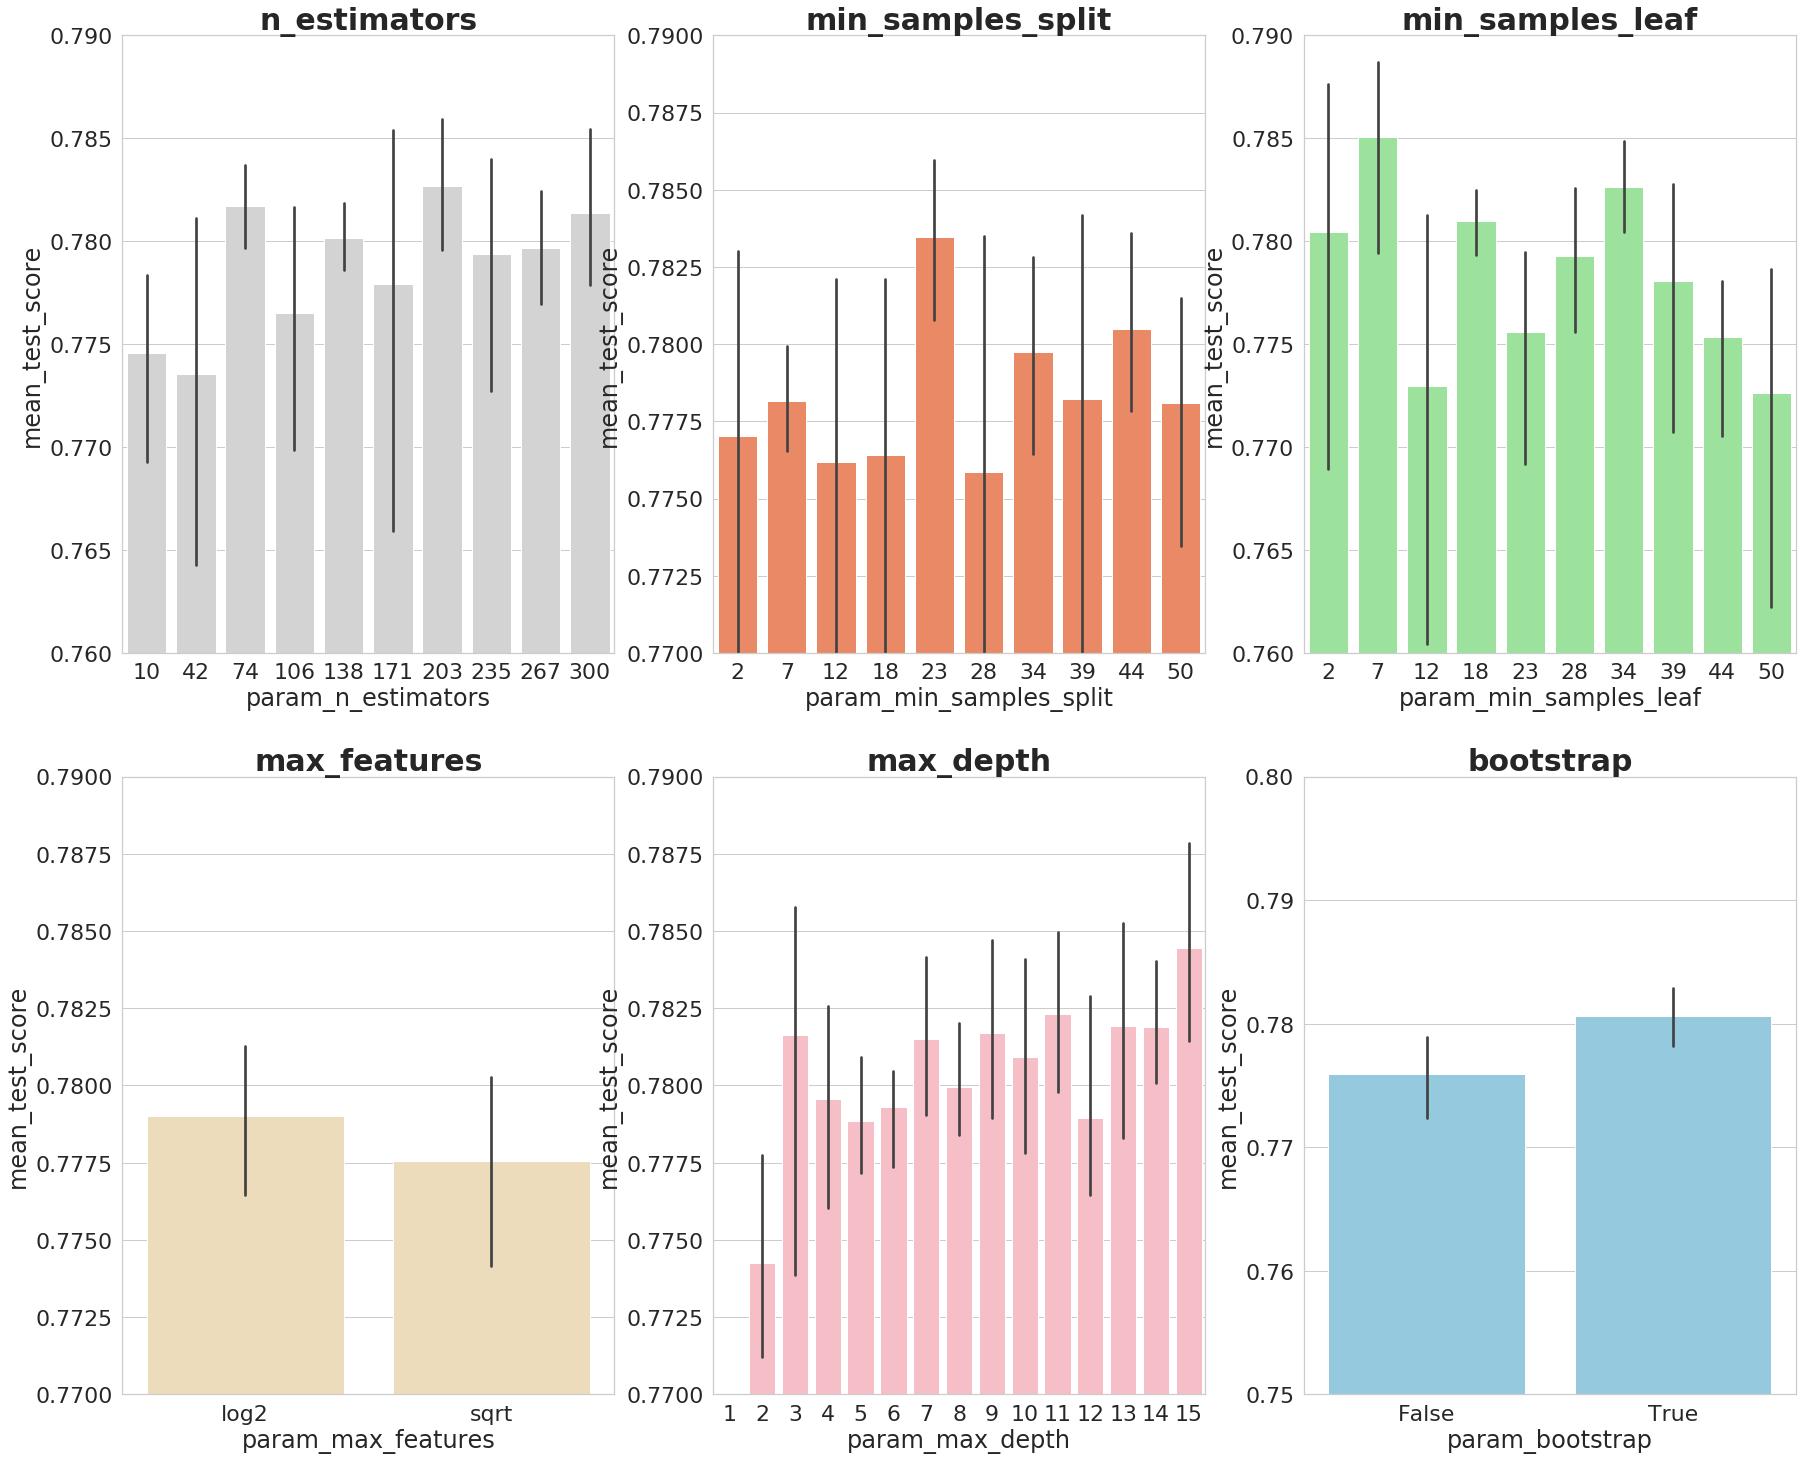

In [66]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.76,.79])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.77,.79])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.76,.79])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.77,.79])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.77,.79])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.75,.80])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

Изучив графики выше, можно сделать вывод, что одним из лучших параметров для модели RandomForestClassifier будет:

    n_estimators: 74, 203
    min_samples_split: 23
    min_samples_leaf: 7
    max_features: 'log2'
    max_depth: 11, 15
    bootstrap: True

In [145]:
model = RandomForestClassifier(random_state=12345,n_estimators=74,min_samples_split=23,min_samples_leaf=7,max_features='log2',max_depth=15,bootstrap=True)
model.fit(features_train,target_train) 
result = accuracy_score(target_valid,model.predict(features_valid))
print('Accuracy:',result)

Accuracy: 0.8164852255054432


Точность идентична расчитанной методом RandomizedSearchCV, что подтверждают наши наблюдения.

Проверим, как эти значяения могут повлиять на точность.

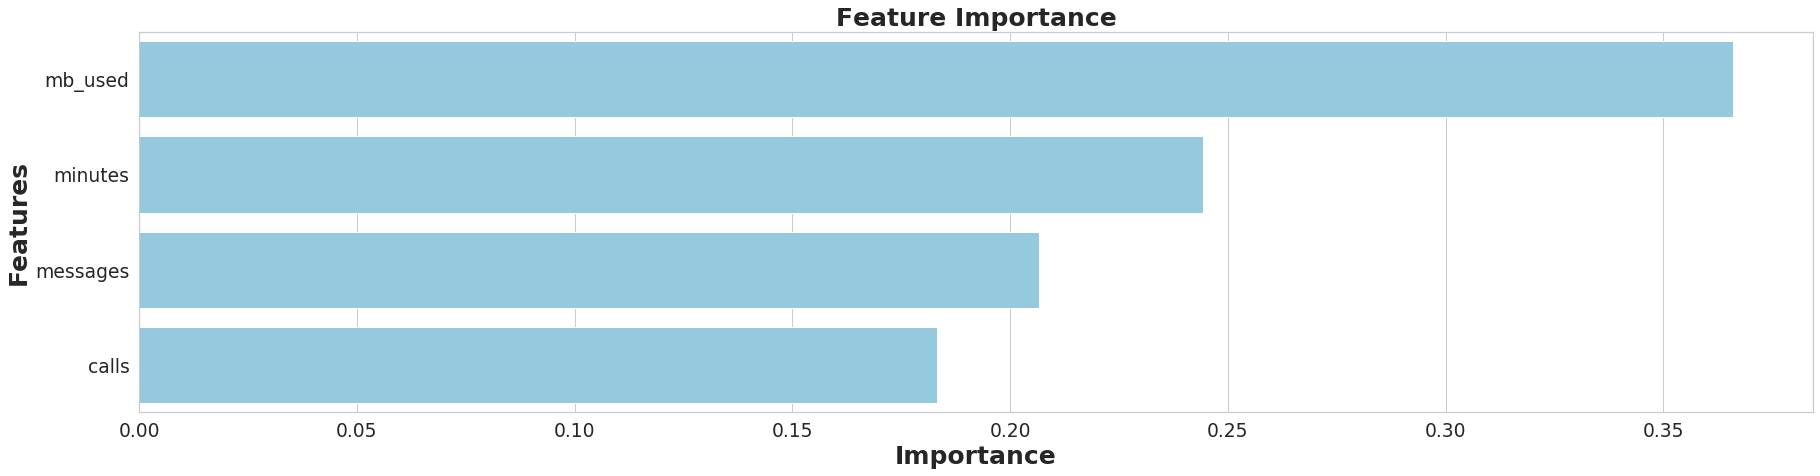

None

,Features,Gini-Importance
0,mb_used,0.366077
1,minutes,0.244196
2,messages,0.206532
3,calls,0.183195


In [28]:
feats = {}
for feature, importance in zip(df.columns, model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,7)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

Самым важным признаком является количество использованных мегабайт, а самым не значимым количество звонков.

После применения алгоритма RandomizedSearchCV воспользуемся алгоритмом GridSearchCV для проведения более точного поиска наилучшей комбинации гиперпараметров. Здесь исследуются те же гиперпараметры, но теперь мы применяем более «обстоятельный» поиск их наилучшей комбинации.

In [ ]:
# Алгоритм GridSearchCV ниже закоментирован, т.к расчет оптимальных параметров уже проведен и подставален в параметры модели
'''params = {
    'max_depth': list(range(5, 40,1)),
    'n_estimators': list(range(1, 40,1)),
    'bootstrap': [True, False]
}

# воспользуемся GridSearchCV для поиска наилучших гиперпараметров
random_forest_model = GridSearchCV(RandomForestClassifier(random_state=12345, n_jobs=-1), params, cv=5, n_jobs=-1, verbose=10)
random_forest_model.fit(features_train, target_train)
print(f'Параметры наилучшей модели: {random_forest_model.best_params_}')
print(f'Accuracy: {random_forest_model.best_score_}')'''

In [144]:
random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=35, max_depth=11,bootstrap=True)
random_forest_model.fit(features_train,target_train) 
pred=random_forest_model.predict(features_valid)
result = accuracy_score(target_valid,pred)
print('Accuracy:',result)

Accuracy: 0.8087091757387247


Алгоритм GridSearchCV не значительно отличается по точности предсказаний.

In [147]:
result = accuracy_score(target_valid,model.predict(features_valid))
pred=model.predict(features_valid)
print(f'Accuracy: {accuracy_score(target_valid, pred):.2f}')
print(f'Precision: {precision_score(target_valid, pred):.2f}')
print(f'Recall: {recall_score(target_valid, pred):.2f}')
print(f'MSE: {mean_squared_error(target_valid, pred):.2f}')

Accuracy: 0.82
Precision: 0.80
Recall: 0.54
MSE: 0.18


## Проверка модели на тестовой выборке

In [149]:
pred = model.predict(features_test)
print(f'Accuracy: {accuracy_score(target_test, pred):.2f}')

Accuracy: 0.81


81% правильных ответов.

## Проверка модели на адекватность

In [140]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Доля большего класса тестовой выборки равна ~0.69 (Смарт); полученная нами модель имеет accuracy ~0.82. Таким образом, мы можем считать модель адекватной для использования.

In [161]:
model = DummyClassifier(strategy = 'most_frequent', random_state = 12345) 
model.fit(features_train,target_train)
print('Accuracy', accuracy_score(target_valid,model.predict(features_valid)))

Accuracy 0.6936236391912908


**Вывод:**

В ходе исследования мы обучили и проверили точность трех моделей:

    - Дерево решений
    - Случайный лес
    - Логистическая регрессия

Для решения задачи классификации пользователей по тарифам Smart и Ultra предлагается использовать модель RandomForestClassifier с параметрами: 


    n_estimators: 74, 203
    min_samples_split: 23
    min_samples_leaf: 7
    max_features: 'log2'
    max_depth: 11, 15
    bootstrap: True
с данными параметрами модель обладает высоким показателем Accuracy и Recall т.е. наиболее точно классифицирует пользователей при низкой среднеквадратичной ошибке.

Точность итоговой модели составляет: **0.82**